##### Detección de tópicos en ciencia básica: topicos con modelo entrenado

1. Filtrar documentos
2. Aplicar tf-idf
3. Guardar



#### **To do** 
- detectar en inngles
- Documentos repetidos entre repositorios y convocatorias
- mismo proyecto 
-


In [10]:
import pickle

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from os import listdir
from math import sqrt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.tokenize import sent_tokenize, word_tokenize

import heapq
import seaborn as sns

nltk.download('wordnet')
nltk.download('punkt')

stemmer = SnowballStemmer('spanish')

[nltk_data] Downloading package wordnet to /tmp/7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /tmp/7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [29]:
df_texto_eval = pd.read_csv("./data_training.csv")
df_texto_eval = df_texto_eval.reset_index(drop=True)
df_texto_eval = df_texto_eval.drop_duplicates(subset=["ID_PROYECTO","NUMERO_CONVOCATORIA","ANIO"], keep="last")
texto = df_texto_eval["DESCRIPCION_PROYECTO"]
df_texto_eval.head(1)

,ID_PROYECTO,NUMERO_CONVOCATORIA,ANIO,USUARIO,CVU,NOMBRE,CVE_RCEA,AREA,DISCIPLINA,SUBDISCIPLINA,INSTITUCION,PAIS,ESTADO,DEPENDENCIA,SUBDEPENDENCIA,DESCRIPCION_PROYECTO,PALABRAS_CLAVE1,PALABRAS_CLAVE2,PALABRAS_CLAVE3
2,1105,PROBLEMAS-2015-01,2015,X_aperez58970,58970,ARTURO PEREZ VAZQUEZ,RCEA-06-17175-2009,CIENCIAS FISICO MATEMATICAS Y CIENCIAS DE LA T...,MATEMATICAS,NaN,COLEGIO DE POSTGRADUADOS EN CIENCIAS AGRICOLAS,MEXICO,VERACRUZ,CAMPUS VERACRUZ,CAMPUS VERACRUZ,mund actual alt dinam complej condicion socioa...,Inteligencia artificial,Agricultura urbana y periurbana,Sistema de soporte de decisiones


#### obtener tfidf
 regresa matriz documentos raices

In [15]:
texto = df_texto_eval["DESCRIPCION_PROYECTO"]

In [16]:
n_features = 512 #number of max words
n_top_words = 30 #words per topic

doc_similarity_thr = 0.15

In [17]:
max_df = .15
min_df = 5

In [14]:
df_texto_eval.shape

(2397, 19)

In [25]:
tfidf_vectorizer = TfidfVectorizer(max_df= max_df, min_df=min_df,
                                   max_features=n_features)

tfidf = tfidf_vectorizer.fit_transform(texto)

In [7]:
df_texto_eval.head()

,ID_PROYECTO,NUMERO_CONVOCATORIA,ANIO,USUARIO,CVU,NOMBRE,CVE_RCEA,AREA,DISCIPLINA,SUBDISCIPLINA,INSTITUCION,PAIS,ESTADO,DEPENDENCIA,SUBDEPENDENCIA,DESCRIPCION_PROYECTO,PALABRAS_CLAVE1,PALABRAS_CLAVE2,PALABRAS_CLAVE3
2,1105,PROBLEMAS-2015-01,2015,X_aperez58970,58970,ARTURO PEREZ VAZQUEZ,RCEA-06-17175-2009,CIENCIAS FISICO MATEMATICAS Y CIENCIAS DE LA T...,MATEMATICAS,NaN,COLEGIO DE POSTGRADUADOS EN CIENCIAS AGRICOLAS,MEXICO,VERACRUZ,CAMPUS VERACRUZ,CAMPUS VERACRUZ,mund actual alt dinam complej condicion socioa...,Inteligencia artificial,Agricultura urbana y periurbana,Sistema de soporte de decisiones
5,1775,PROBLEMAS-2015-01,2015,X_hgonzalez164212,206295,HUMBERTO GONZALEZ GALBAN,RCEA-05-15877-2008,CIENCIAS SOCIALES,ECONOMIA,NaN,"EL COLEGIO DE LA FRONTERA NORTE, A.C.",MEXICO,BAJA CALIFORNIA,CENTRO DE ESTUDIOS FRONTERIZOS DEL NORTE DE ME...,CENTRO DE ESTUDIOS FRONTERIZOS DEL NORTE DE ME...,polit public enfrent pobrez extrem mediant dis...,Pobreza extrema,Seguridad alimentaria,Perdidas y desperdicios de alimentos
8,1876,PROBLEMAS-2015-01,2015,X_jarzate122299,122299,JORGE GUADALUPE ARZATE SALGADO,RCEA-05-11490-2006,CIENCIAS SOCIALES,SOCIOLOGIA,NaN,UNIVERSIDAD AUTONOMA DEL ESTADO DE MEXICO,MEXICO,"M+XICO, EDO. DE",FACULTAD DE CIENCIAS POLITICAS Y ADMINISTRACIO...,FACULTAD DE CIENCIAS POLITICAS Y ADMINISTRACIO...,grup fortalec capac econom natanael ramirez an...,Pobreza,Seguridad alimentaria,Capacidades
14,273,PROBLEMAS-2015-01,2015,X_mvalladares36446,36446,MARIA GUADALUPE VALLADARES CISNEROS,RCEA-02-18283-2009,CIENCIAS AGROPECUARIAS Y BIOTECNOLOGIA,MEDICINA VETERINARIA,NaN,UNIVERSIDAD AUTONOMA DEL ESTADO DE MORELOS,MEXICO,MORELOS,FACULTAD DE CIENCIAS QUIMICAS E INGENIERIA,FACULTAD DE CIENCIAS QUIMICAS E INGENIERIA,explicacion mexic parasitosis caus principal e...,Mecanismo de accion compuestos secundarios pla...,NaN,NaN
18,857,PROBLEMAS-2015-01,2015,X_mlizardi164087,164087,MANUEL ALEJANDRO LIZARDI JIMENEZ,RCEA-06-26342-2013,INGENIERIA Y TECNOLOGIA,INGENIERIA QUIMICA,NaN,INSTITUTO TECNOLOGICO SUPERIOR DE TIERRA BLANCA,MEX,DF,INSTITUTO TECNOLOGICO SUPERIOR DE TIERRA BLANCA,INSTITUTO TECNOLOGICO SUPERIOR DE TIERRA BLANCA,identificacion prioritari nacional atend marc ...,Lixiviado,Agua residual,Tratamiento fisicoquimicogalvanico


# 1. Tópicos

In [34]:
ex = ['mund actual alt dinam complej condicion socioambiental estan cambi rap conform interaccion proces global cambi climat cual estan emerg sinergi imprev desarroll cienci tecnologi aceler part nuev patron acces informacion financi sistem social vuelt dinam nunc deb dinam poblacional plural urbanizacion relacion econom movil person practic patogen ide tecnologi context hypercomplej tom decision inversion desarroll innovacion polit public requier nuev conjunt marc teoric herramient permit resolv problem optimizacion multiojet asoci dich decision adem permit incorporacion informacion nuev relev tiemp intencion gener sistem decision adapt capaz respond cambi entron poblacion urban mund millon dispar dec posterior numer person viv zon urban millon super numer viv zon rural millon desd entonc mund vuelt urban rural alcanz millon person division poblacion departament asunt econom social nacion unid poblacion predij entonc poblacion urban crecer millon particul mexic segun actual poblacion urban aument segun prediccion consej nacional poblacion conap adem ciudad convert centr pobrez desiguald ten hast poblacion situacion pobrez dec ciud comienz ecosistem pobl human maner cualqui vision desarroll sosten inclu vision ciud sosten objet principal present proyect comenz constru sistem soport decision bas inteligent artificial abord problem socioambiental intencion ayud ciudad mexican transit haci sostenibil intencion proyect ten continu dentr program problem nacional conacyt obten fond bianual desarroll diferent modul sistem inteligent soport decision convocatori pretend comenz modul sistem pretend atend tem prioritari ciudad desarroll urban combat pobrez segur alimentari circunscrit fisic matemat cienci tierr ahor concept sostenibil acept universal consideracion import practic tod proces sociopolit decision embarg mism tiemp experiment aument precedent tant nuestr patron consum emision gas efect invernader hech durant recient cumbr nacion unid copenhag sobr alcanz acuerd real sobr reduccion gas efect invernader muestr contradiccion socied modern acog sent cambi mism tiemp continu patron comport reflej patron consum aliment ciudad bas importacion aliment gener esquem insegur alimentari pes tas altas pobrez todavi zon rural discut anterior esper tendenci cambi insegur alimentari rural necesari superior ciudad hech indic figur pais desarroll incident insegur alimentari med deficient energi alimentari zon urban igual mayor camp aunqu are urban promedi tien ingres altos escenari insegur alimentari urban tant pobrez urban result esencial comprend contribucion agricultur urban periurban pued ten primer instanci acces aliment condicion segur alimentari rar excepcion mund sequi guerr hambrun dispon aliment nivel adecu cubr neces minim mayori poblacion inclus rural menud abund zon urban embarg garanti tod segment poblacion tendr acces suficient oportun estos aliment probabl nieg acces pobr vulner aisl socied dec problem insegur alimentari fundamental iniqu context contribu segur alimentari urban mediant aument disponibil aliment estabil ciert med accesibil agricultur urban periurban med produc aliment aument disponibil aliment contribu ofert global entorn urban part import produccion comercial product fresc llev zon periurban tien ventaj compar termin merc distanci tant contribucion signific ofert aliment fresc horticultur frut huev lech corral zon urban aunqu contribucion vari ciud ciud contribucion verdur cultiv zon urban periurban tant vari diferent ciudad african entre windhoek gaboron lilongw blantyr nampul segun verdur zalem produccion aliment basic zon urban vist mecan supervivent situacion grav insegur alimentari orient consum hogar mayori region mund diet salud requier combinacion adecu micr macronutrient satisfac neces individu ten cuent estad salud factor part respons prevencion habit urban logr diet salud pobrez falt aliment fresc hogar pobr pued pag regular compr aliment pereceder contien micronutrient esencial especial import inclus consider monetari deb problem abastec estos product ser period escas costos form hogar cerc situacion pobrez pued entrar alimentari emple ingres proporcion tambi ofrec potencial alivi insegur alimentari pobrez urban efect principal trav emple asalari propi agricultor urban familiar vecin tempor adem proporcion amortigu pobr tiemp emergent pued manten nivel segur alimentari ahor segun factor med determin pued ten impact signific segur alimentari nutricion urban particul simpl produc qui qui consum tambi import determin produc com estacional produccion estos antecedent objet especif prim modul sistem inteligent soport decision transit esquem ciud sosten dis indic pobrez alimentari urban bas concept segur alimentari determin numer distribucion hogar situacion pobrez ciud mexic mediant trabaj camp identific red actual product productor consumidor determinacion balanc consumoproduccion aliment energet usand aprendizaj maquin buscari entend condicion red actual exit ciud mexic intencion posterior dis nuev red dich caracterist adicional usand metodologi propuest buscari estas nuev red fuer red complej adapt capac escal facil robust cambi entorn merc depend control central realiz analisis econometr cost benefici transit red actual propuest determin impact potencial esquem combat pobrez urban ciud mexic estudi econometr podri serv dise calcul equivalent global calculator httpuncachedsiteglobalcalculatororg permit compar diferent escenari configuracion ciud mexic ultim podri part continuacion propuest present segund period program problem nacional implement plataform computacional coadyuv transit actual propuest mediant incorporacion divers mecan generacion red comercializacion promocion red dich plataform tendri motor cuantit desarroll bas rshiny import seal desarroll tecnolog hari lineamient softwar libr propuest fundacion softwar libr wwwfsforg liberari usand licenci garantiz desarroll pued usad distribu modific librement mediant estudi mineri text analisis discurs medir plataform desarroll cambi model mental agent red tien consider present proyect tien contribucion cientif ontolog aport element nuev definicion multidimensional pobrez asim mediant objet avanz entend caus pobrez especif ciudad final contribucion metodolog cuant dise red complej adapt proyect interdisciplinari cont siguient colabor pabl padill investig titul sniiii iim padill colabor termin analisis red econometr elvi ramirez carrill investig posdcotoral ramirez particip concernient agricultur urban barahon catedrat conacyt imateunam barahon apoy mineri text analisis econometr general equip pobrez urban multidimensional iidsesiber inclu graciel teruel sniiii mirey vil vaness perezcirer miguel rey referent population reach herald glob retriev httpwwwunorgendevelopmentdesapopulationpublicationsurbanizationurbanruralshtml current world population unit nations department economic social affairs retriev plan integral movil lineamient movil urban sustent sedesol diagnost program habitat davidson m2010 hack sustainability scienc ideology cynical blockag hum geography coh garrett pric crisis urban security environment urbanization 467482 nugent august urban periurb agricultur household security nutrition electronic conferenc urban periurb agricultur policy agend httpwwwruaf orginfo_market valst meershoek urban agricultur household security nutrition southern afric proc subregional expert consultation simpl technologi diversification small scal farmers urban periurb are southern afric university stellenbosch stellenbosch 143147 gershenson design control selforganizing systems copit arxiv mackay sustain energywithout cambridgeal proyect interdisciplinari cont siguient colabor pabl padill investig titul sniiii iim padill colabor termin analisis red econometr elvi ramirez carrill investig posdcotoral ramirez particip concernient agricultur urban barahon catedrat conacyt imateunam barahon apoy mineri text analisis econometr general equip pobrez urban multidimensional iidsesiber inclu graciel teruel sniiii mirey vil vaness perezcirer miguel rey marian espinoz doctor trabaj visualizacion dat comunicacion cienciael mund actual alt dinam complej condicion socioambiental estan cambi rap conform interaccion proces global cambi climat cual estan emerg sinergi imprev desarroll cienci tecnologi aceler part nuev patron acces informacion financi sistem social vuelt dinam nunc deb dinam poblacional plural urbanizacion relacion econom movil person practic patogen ide tecnologi context hypercomplej tom decision inversion desarroll innovacion polit public requier nuev conjunt marc teoric herramient permit resolv problem optimizacion multiojet asoci dich decision adem permit incorporacion informacion nuev relev tiemp intencion gener sistem decision adapt capaz respond cambi entron poblacion urban mund millon dispar dec posterior numer person viv zon urban millon super numer viv zon rural millon desd entonc mund vuelt urban rural alcanz millon person division poblacion departament asunt econom social nacion unid poblacion predij entonc poblacion urban crecer millon particul mexic segun actual poblacion urban aument segun prediccion consej nacional poblacion conap adem ciudad convert centr pobrez desiguald',' ten hast poblacion situacion pobrez dec ciud comienz ecosistem pobl human maner cualqui vision desarroll sosten inclu vision ciud sosten ahor concept sostenibil acept universal consideracion import practic tod proces sociopolit decision embarg mism tiemp experiment aument precedent tant nuestr patron consum emision gas efect invernader muestr contradiccion socied modern acog sent cambi mism tiemp continu patron comport reflej patron consum aliment ciudad bas importacion aliment gener esquem insegur alimentari pes tas altas pobrez todavi zon rural discut anterior esper tendenci cambi insegur alimentari rural necesari superior ciudad hech indic figur pais desarroll incident insegur alimentari med deficient energi alimentari zon urban igual mayor camp aunqu are urban promedi tien ingres altos escenari insegur alimentari urban tant pobrez urban result esencial comprend contribucion agricultur urban periurban pued ten primer instanci acces aliment condicion segur alimentari rar excepcion mund sequi guerr hambrun dispon aliment nivel adecu cubr neces minim mayori poblacion inclus rural menud abund zon urban embarg garanti tod segment poblacion tendr acces suficient oportun estos aliment probabl nieg acces pobr vulner aisl socied dec problem insegur alimentari fundamental iniqu context contribu segur alimentari urban mediant aument disponibil aliment estabil ciert med accesibil agricultur urban periurban med produc aliment aument disponibil aliment contribu ofert global entorn urban part import produccion comercial product fresc llev zon periurban tien ventaj compar termin merc distanci tant contribucion signific ofert aliment fresc horticultur frut huev lech corral zon urban aunqu contribucion vari ciud ciud contribucion verdur cultiv zon urban periurban tant vari diferent ciudad african entre windhoek gaboron lilongw blantyr nampul segun verdur zalem produccion aliment basic zon urban vist mecan supervivent situacion grav insegur alimentari orient consum hogar mayori region mund diet salud requier combinacion adecu micr macronutrient satisfac neces individu ten cuent estad salud factor part respons prevencion habit urban logr diet salud pobrez falt aliment fresc hogar pobr pued pag regular compr aliment pereceder contien micronutrient esencial especial import inclus consider monetari deb problem abastec estos product ser period escas costos form hogar cerc situacion pobrez pued entrar alimentari emple ingres proporcion tambi ofrec potencial alivi insegur alimentari pobrez urban efect principal trav emple asalari propi agricultor urban familiar vecin tempor adem proporcion amortigu pobr tiemp emergent pued manten nivel segur alimentari ahor segun factor med determin pued ten impact signific segur alimentari nutricion urban particul simpl produc qui qui consum tambi import determin produc com estacional produccion upael objet principal present proyect comenz constru sistem soport decision bas inteligent artificial abord problem socioambiental intencion ayud ciudad mexican transit haci sostenibil intencion proyect ten continu dentr program problem nacional conacyt obten fond bianual desarroll diferent modul sistem inteligent soport decision convocatori pretend comenz modul sistem pretend atend tem prioritari ciudad desarroll urban combat pobrez segur alimentari circunscrit fisic matemat cienci tierracon estos antecedent objet especif prim modul sistem inteligent soport decision transit esquem ciud sosten dis indic pobrez alimentari urban bas concept segur alimentari determin numer distribucion hogar situacion pobrez ciud mexic mediant trabaj camp identific red actual product productor consumidor determin balanc consumoproduccion aliment energet usand aprendizaj maquin busc entend condicion red actual exit ciud mexic intencion posterior dis nuev red dich caracterist adicional usand metodologi propuest buscari estas nuev red fuer red complej adapt capac escal facil robust cambi entorn merc depend control central realiz analisis econometr identific algun causal pobrez alimentari urban hac primer valoracion determin impact potencial combat pobrez urban ciud mexic estudi econometr podri serv dise prim prototip calcul podri crec equivalent global calculator httpuncachedsiteglobalcalculatororg permit compar diferent escenari configuracion ciud mexic ultim podri part continuacion propuest present segund period program problem nacional implement plataform computacional coadyuv transit actual propuest mediant incorporacion divers mecan generacion red comercializacion promocion red dich plataform tendri motor cuantit desarroll bas rshiny import seal desarroll tecnolog hari lineamient softwar libr propuest fundacion softwar libr wwwfsforg liberari usand licenci garantiz desarroll pued usad distribu modific librement consider present proyect tien contribucion cientif ontolog aport element nuev definicion multidimensional pobrez urban asim mediant objet avanz entend caus pobrez alimentari urban final contribucion metodolog import avanz reconceptualizacion pobrez alimentari urban consider ejempl cast basic observ normat bas requer nutricional min ten primer medicion diagnost pobrez alimentari urban nuev perspect promov analisis red urban gener mism dinam ciud unid minim analisis problem socioambiental evalu part estudi econometr papel potencial agricultur urban periurban mitigacion pobrez alimentari urban pobrez urban general mexic observ clar causal bidireccional entre pobrez acces alimentacion acuerd result obten encuest nacional salud nutricion ensanut acces alimentacion concept multidimensional complej adem mexic reconoc tant derech human derech constitucional definicion torn acces alimentari subray cualqui proces adquisicion aliment permit alcanz aliment apropi nutrit dec alimentacion cuantit cualit adecu suficient garantic satisfactori dign exist divers indic med acces alimentacion comun utiliz naturalez multidimensional segur alimentari defin organizacion nacion unid alimentacion agricultur situacion tod person tien acces fisic econom suficient aliment inocu satisfac neces alimentici preferent cuant aliment llev activ sanafa concept segur alimentari operacionaliz mediant divers indic cual enlist continuacion escal percepcion segur alimentari estas escal evalu experient insegur alimentari adult hog mexic escal latinoamerican caribe segur alimentari elcsa represent indic utiliz percepcion segur alimentari instrument captur nivel preocupacion percib individu relacion adquisicion aliment nivel calid divers cantid com sacrific disminucion porcion compromet durant mes previ dificult implic adquisicion aliment tambi exist escal mexican segur alimentari retom pregunt elcsa divers dietet consider indic evalu adecuacion consum aliment nivel individual hogar instrument evalu divers dietet cuantit mediant list aliment consum period determin determin numer grup aliment consum period tiemp cafier melgarquionez ballard keppl indic represent element fundamental evalu calid diet consider varied aliment inclu diet individu hog asegur ingestion adecu tant energi nutriment esencial promuev salud leroy proporcion gast destin aliment indic especif numer aliment adquir part ingres corrient hog inclu aliment compr aliment consum produc hog gast aliment nivel hog utiliz indic vulner econom hogar gast mayor part ingres adquisicion aliment tien riesg increment privacion mism radic estos hogar disminu nivel ingres ver oblig disminu numer aliment adquir smith subandor adecuacion energet exist asociacion entre falt acces aliment insuficient ingest energet part posibl utiliz adecuacion energet person indic acces aliment hac cuantif consum aliment person determin calori aport aliment consum obten result consum energet total merec subray indic pued cuestion preci relat aliment calid nutricional densid energet promuev hogar menor ingres consum mayor cantid product altos azucar refin gras vilarcompt sandovalolascoag perez lizaur indic inocu aliment aspect relev acces aliment radic asegur poblacion aliment consum inocu signif segur dec implic riesg salud arisp tapi consider acces aliment pued med trav indic evalu inocu aliment consum sent indic pued proporcion informacion frecuenci enfermedad gastrointestinal intox alimentari enfermedad diarreic import ambos indic radic estas enfermedad transmit aliment contamin agent patogen recurrent estas patologi indic aliment consum inocu valor pertinent representat levant dat pobrez alimentari implement siti dond ciudadan ciud mexic pued contest form voluntari cuestionari asoci indic mencion context cienci ciudadan cre estudi urban penetracion tecnologi seri limit representat discriminacion estudi cualqui form contempl tambi hac ejercici moder trabaj camp valid dat levant line mediant trabaj camp realizari alianz organiz civil establec sobr agricultur urban periurban identific red produccion consum import tiemp establec divers metadat despu usari realiz arbol clasificacion usand algoritm implement plataform machin learn arbol clasificacion identific condicion cual red exit estan obten buen result conoc usar dis marc trabaj propuest red complej adapt permit crecimient red actual usand algoritm infomap rusvall colabor analisis red ciud identific acopl adecu red productor red propi ciud proyect dividir etap anual period semestral cual realiz siguient activ activ period propuest indic pobrez alimentari urban generacion siti cienci ciudadan dond mont cuestionari asoci indic dond subir distint material divulgacion problem bas dat distint visualiz dat dise trabaj camp inici mism levant dat line activ period trabaj camp levant dat line analisis dat generacion primer result presentacion primer result congres nacional internacional redaccion articul envi mism activ period analisis econometr prototip calcul analisis nuev dat generacion aplic rshiny equivalent redaccion articul envi mism comienz transferent tecnologi difusion result entre red establec activ period redaccion articul envi mism presentacion result final congres nacional internacional publicacion material digital plataform computacional gener transferent tecnologi difusion result entre red establec median plaz esper ten prim modul sistem soport decision oper siend usad deferent actuant red productor agricultur urban periurban distint red consumidor tomador decision larg plaz incorporacion nuev modul tien contempl segund modul trat sobr seleccion optim rut movil motoriz particul objet segund modul seri gener sistem seleccion rut optim ciclism urban usand inteligent artificial primer usar esquem proces jerarqu analit comun expert adecu identific caracterist fundamental constitu buen ciclist ambient urban posterior realiz trabaj camp evalu result punt anterior muestr suficient rut ciud mexic estos result usand mineri dat gener algoritm evaluacion rut ciclism urban pued implement plataform computacional final gener colabor esquem cienci ciudadan aptitud ciclist call ciud mexic avanz implementacion calcul automat rut optim larg plaz esperari ten sistem soport decision relacion divers problem socioambiental cuy respuest fomentari transit haci ciud sosten principi pud export otras ciudad proyect interdisciplinari cont siguient colabor pabl padill investig titul sniiii iim padill colabor termin analisis red econometr elvi ramirez carrill investig posdcotoral ramirez particip concernient agricultur urban barahon catedrat conacyt imateunam barahon apoy mineri text analisis econometr irving moral investig asoci c3unam realiz analisis red c3unam antropolog apoy dise supervision trabj camp general equip pobrez urban multidimensional iidsesiber inclu graciel teruel sniiii mirey vil vaness perezcirer miguel rey snii1 dise indic pobrez alimentari urban primer evaluacion indic usand sobr estudi red productor agricultur urban periurban propuest redise mism context red complej adapt prototip plataform computacional line permit medicion continu indic pobrez alimentari urban dond pued visualiz red productor pued corr diferent escenari organizacion mism presentacion result proyect congres nacional internacional entre publicacion articul cientif revist arbitr circulacion internacional entre vigent teng somet proyect convocatori saludconacyt1 population reach herald glob retriev httpwwwunorgendevelopmentdesapopulationpublicationsurbanizationurbanruralshtml current world population unit nations department economic social affairs retriev plan integral movil lineamient movil urban sustent sedesol diagnost program habitat davidson m2010 hack sustainability scienc ideology cynical blockag hum geography coh garrett pric crisis urban security environment urbanization 467482 nugent august urban periurb agricultur household security nutrition electronic conferenc urban periurb agricultur policy agend httpwwwruaf orginfo_market valst meershoek urban agricultur household security nutrition southern afric proc subregional expert consultation simpl technologi diversification small scal farmers urban periurb are southern afric university stellenbosch stellenbosch 143147 gershenson design control selforganizing systems copit arxiv mackay sustain energywithout cambridg ']

In [36]:
tfidf_vectorizer.transform(ex).todense()

matrix([[0.05302047, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.03746733, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

Fit the NMF model (generalized Kullback-Leibler divergence)

In [19]:
n_components = 50
n_components # borrar con nuevos docs

50

In [11]:
import time
t0 = time.time()

topic_model = NMF(n_components=round(n_components), random_state=123,
                  beta_loss='kullback-leibler', solver='mu', max_iter=200, alpha=.1,
                  l1_ratio=.5)

topic_model.fit(tfidf)

t1 = time.time()
total = t1-t0
print(total)

32.821455001831055


guardamos el vocabulario de TFIDF

In [12]:
feature_names = tfidf_vectorizer.get_feature_names()

In [13]:
topic_data = []

for topic_idx, topic in enumerate(topic_model.components_):
    index = [i for i in range(len(topic))]
    words = [feature_names[i] for i in index]
    value = [topic[i] for i in index]
    #print(value)
    topic_data.append({"index":index, "words":words, "value":value})


In [14]:
filter_id = "AAA"

df_topicos_nombre = pd.DataFrame([t['words'] for t in topic_data])
df_topicos_nombre.index = [filter_id + str(t).zfill(3) for t in df_topicos_nombre.index]
df_topicos_nombre.columns = ['W'  + str(w+1).zfill(2) for w in df_topicos_nombre.columns]
df_topicos_nombre.iloc[:2,range(20)]

,W01,W02,W03,W04,W05,W06,W07,W08,W09,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19,W20
AAA000,abastec,abej,aceit,acomp,acondicion,activity,acuat,acuicol,acuifer,acuos,adiccion,adit,adolescent,adopcion,adsorcion,aed,aegypti,aere,agav,agend
AAA001,abastec,abej,aceit,acomp,acondicion,activity,acuat,acuicol,acuifer,acuos,adiccion,adit,adolescent,adopcion,adsorcion,aed,aegypti,aere,agav,agend


In [15]:
df_topicos = pd.DataFrame([t['value'] for t in topic_data])
df_topicos.index = [filter_id + str(t).zfill(3) for t in df_topicos.index]
df_topicos.columns = ['W'  + str(w+1).zfill(2) for w in df_topicos.columns]
df_topicos.head(2)

,W01,W02,W03,W04,W05,W06,W07,W08,W09,W10,...,W503,W504,W505,W506,W507,W508,W509,W510,W511,W512
AAA000,0.000000,0.0,0.000785,0.054205,0.000000,0.054426,0.0,0.0,0.000000e+00,0.000003,...,0.0,0.000000,0.000105,0.01477,0.0,0.000000,0.0,0.0,0.0,0.000000
AAA001,0.033825,0.0,0.004528,0.000000,0.007924,0.000000,0.0,0.0,1.901295e-11,0.071701,...,0.0,0.334634,0.000000,0.00000,0.0,0.062378,0.0,0.0,0.0,0.002046


# 2.  Top N palabras 

## valor

In [16]:
lista_nlargest = [df_topicos.iloc[topic,:].nlargest(n=50) for topic in range(df_topicos.shape[0])]

In [17]:
df_words = pd.DataFrame(index=[number for number in range(df_topicos.shape[0])],
                        columns=["word"+str(numero) for numero in range(50)])
for row in range(df_words.shape[0]):
    df_words.iloc[row,:] = lista_nlargest[row].values

In [18]:
df_words.head()

,word0,word1,word2,word3,word4,word5,word6,word7,word8,word9,...,word40,word41,word42,word43,word44,word45,word46,word47,word48,word49
0,1.20496,0.938617,0.925176,0.924458,0.907826,0.691286,0.674181,0.671704,0.640741,0.639349,...,0.129963,0.127746,0.126406,0.1227,0.122024,0.120008,0.115644,0.115624,0.113455,0.112347
1,1.14279,0.87139,0.647753,0.639685,0.55067,0.528141,0.48507,0.449356,0.445199,0.425976,...,0.17635,0.163692,0.162195,0.15953,0.15604,0.148911,0.144669,0.138238,0.12795,0.12314
2,0.92549,0.865021,0.864772,0.853093,0.816172,0.781374,0.666229,0.653532,0.619045,0.60628,...,0.137802,0.136027,0.134929,0.131024,0.124245,0.12259,0.120242,0.115595,0.113137,0.101931
3,0.98946,0.846195,0.702559,0.571105,0.569115,0.539171,0.507209,0.501104,0.47798,0.462652,...,0.174936,0.16177,0.157906,0.150808,0.143303,0.140778,0.128895,0.128804,0.128172,0.12694
4,1.16915,1.14682,0.83356,0.634356,0.570562,0.504817,0.479698,0.470618,0.469729,0.42228,...,0.166108,0.165596,0.16113,0.15588,0.13939,0.139365,0.136455,0.135885,0.13066,0.129506


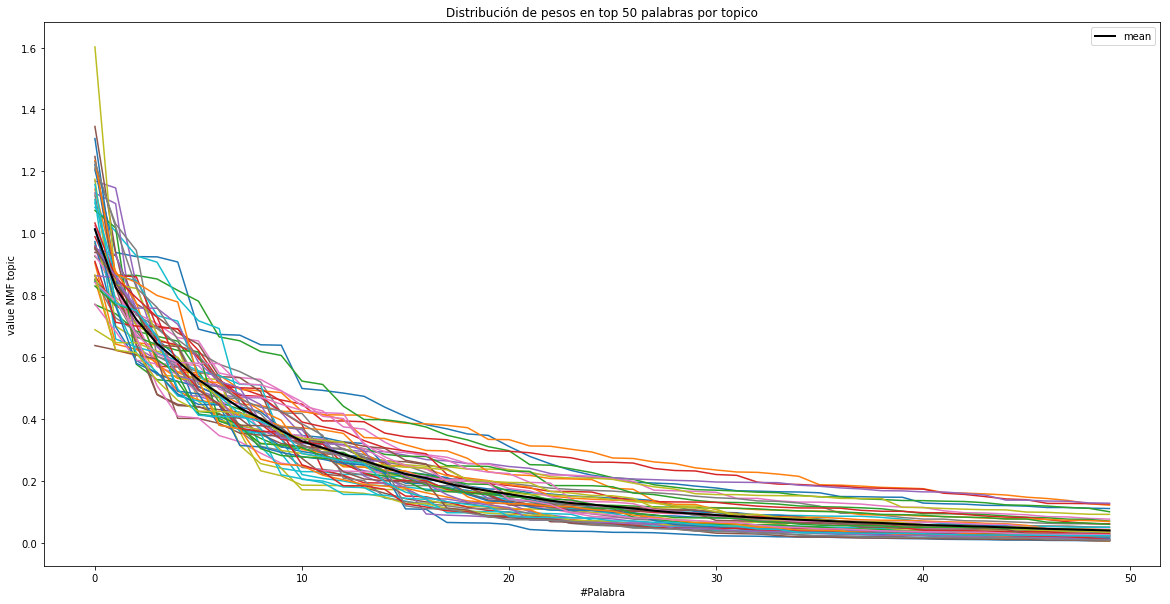

In [20]:
fig = plt.figure(figsize=(20,10))

ax = plt.axes()
numerize = [i for i in range(50)]
for topic in range(df_words.shape[0]):
    x = df_words.iloc[topic,:].values
    ax.plot(numerize,x)
ax.plot(numerize,df_words.mean(axis=0),label="mean",linewidth=2,color="black")
ax.set(xlabel='#Palabra', ylabel='value NMF topic',
       title='Distribución de pesos en top 50 palabras por topico')
ax.legend()
plt.show()

### palabra

In [21]:
df_words_name = pd.DataFrame(index=[number for number in range(df_topicos.shape[0])],
                        columns=["word"+str(numero) for numero in range(20)])
for row in range(df_words_name.shape[0]):
    lista_index = df_topicos.iloc[row,:].nlargest(n=20).index.tolist()
    df_words_name.iloc[row,:] = df_topicos_nombre.reset_index(drop=True).loc[row,lista_index].values

In [22]:
df_words_name.head()

,word0,word1,word2,word3,word4,word5,word6,word7,word8,word9,word10,word11,word12,word13,word14,word15,word16,word17,word18,word19
0,obes,corporal,insulin,ingest,mellitus,sanguine,sindrom,hipertension,perifer,cardiovascular,arterial,renal,sobrepes,cardiac,inflamacion,hormon,intestinal,medicament,trastorn,colesterol
1,combust,celd,electroquim,solar,electrod,fosil,materials,catod,semiconductor,hidrogen,cap,cinet,cristalin,ray,combustion,cells,fotovolt,oxidacion,circuit,ion
2,tomador,gobi,conceptual,bien,torn,agend,territorial,riquez,asent,conflict,resilient,gobern,colegi,vide,ciudadan,comunitari,remot,transit,pobrez,entid
3,tumoral,tumor,mutacion,anticuerp,pronost,raton,quimioterapi,purific,proliferacion,sealizacion,supervivent,viral,predict,progresion,poz,pulmon,antigen,prostat,recombin,citotox
4,tare,aprendizaj,arquitectur,conferenc,informat,adopcion,inteligent,automat,grafic,valoracion,programacion,transit,virtual,supervis,trayectori,sesion,neuronal,hogar,conceptual,exclusion


# 3. topicos por texto


Asignamos un vectore de topicos para cada texto

In [55]:
lista_topicos = df_topicos.index.tolist()
dataframe_values = pd.DataFrame(columns=lista_topicos, index=[row for row in range(tfidf[:].shape[0])])

In [58]:
topics_results = []
#numero_de_matches = 50
for i_doc in range(tfidf[:].shape[0]):

    valor_topico = [
        np.dot(
            tfidf[i_doc].todense().tolist()[0],
            topic_data[topic_id]["value"]
               ) for topic_id in range(len(topic_data))
                    ] #pesos de topicos
    
    #print([topic["index"] for topic in topic_data])
    #print(i_doc)
    #print(valor_topico)
    #print(np.array([tfidf[i_doc,topic["index"]].sum() for topic in topic_data]) )
    
    #dictionary = valor_topico
    #df de valores unicamente
    dataframe_values.iloc[i_doc,:] = valor_topico

    #appendeamos en el DF:
    #dictionary  = dict(zip(lista_topicos, valor_topico)) # juntar en diccionario palabra-peso
    #df_texto_eval.loc[i_doc,"topic_vector"] = str(dictionary) # si queremos un diccionario
    df_texto_eval.loc[i_doc,"topic_vector"] = str(valor_topico)

In [63]:
dataframe_values.shape

(2397, 50)

In [64]:
df_texto_eval.shape

(4218, 20)

### TF_idf_vector

In [26]:
df_texto_eval.to_csv("./evaluador_topicos.csv", index=False)

In [27]:
df_texto_eval.head(3)

,ID_PROYECTO,NUMERO_CONVOCATORIA,ANIO,USUARIO,CVU,NOMBRE,CVE_RCEA,AREA,DISCIPLINA,SUBDISCIPLINA,INSTITUCION,PAIS,ESTADO,DEPENDENCIA,SUBDEPENDENCIA,DESCRIPCION_PROYECTO,PALABRAS_CLAVE1,PALABRAS_CLAVE2,PALABRAS_CLAVE3,topic_vector
2,1105.0,PROBLEMAS-2015-01,2015.0,X_aperez58970,58970.0,ARTURO PEREZ VAZQUEZ,RCEA-06-17175-2009,CIENCIAS FISICO MATEMATICAS Y CIENCIAS DE LA T...,MATEMATICAS,NaN,COLEGIO DE POSTGRADUADOS EN CIENCIAS AGRICOLAS,MEXICO,VERACRUZ,CAMPUS VERACRUZ,CAMPUS VERACRUZ,mund actual alt dinam complej condicion socioa...,Inteligencia artificial,Agricultura urbana y periurbana,Sistema de soporte de decisiones,"[0.026622450400353777, 0.0005565104038251713, ..."
5,1775.0,PROBLEMAS-2015-01,2015.0,X_hgonzalez164212,206295.0,HUMBERTO GONZALEZ GALBAN,RCEA-05-15877-2008,CIENCIAS SOCIALES,ECONOMIA,NaN,"EL COLEGIO DE LA FRONTERA NORTE, A.C.",MEXICO,BAJA CALIFORNIA,CENTRO DE ESTUDIOS FRONTERIZOS DEL NORTE DE ME...,CENTRO DE ESTUDIOS FRONTERIZOS DEL NORTE DE ME...,polit public enfrent pobrez extrem mediant dis...,Pobreza extrema,Seguridad alimentaria,Perdidas y desperdicios de alimentos,"[0.01685371533487453, 1.4090724872843405, 0.01..."
8,1876.0,PROBLEMAS-2015-01,2015.0,X_jarzate122299,122299.0,JORGE GUADALUPE ARZATE SALGADO,RCEA-05-11490-2006,CIENCIAS SOCIALES,SOCIOLOGIA,NaN,UNIVERSIDAD AUTONOMA DEL ESTADO DE MEXICO,MEXICO,"M+XICO, EDO. DE",FACULTAD DE CIENCIAS POLITICAS Y ADMINISTRACIO...,FACULTAD DE CIENCIAS POLITICAS Y ADMINISTRACIO...,grup fortalec capac econom natanael ramirez an...,Pobreza,Seguridad alimentaria,Capacidades,"[0.11836495486623393, 0.19841586534901073, 0.0..."


# 4.  Vector por evaluador

In [28]:
dataframe_values.head(2)

,AAA000,AAA001,AAA002,AAA003,AAA004,AAA005,AAA006,AAA007,AAA008,AAA009,...,AAA040,AAA041,AAA042,AAA043,AAA044,AAA045,AAA046,AAA047,AAA048,AAA049
0,0.0518802,0.00939512,0.502303,0.0285532,0.474413,0.0101479,0.0161497,0.0144767,0.0643252,0.0114206,...,0.0465413,0.0351701,0.00688335,0.0107873,0.0691935,0.0507202,0.00677934,0.0457019,0.0272538,0.0352445
1,0.0151864,0.0109614,0.176758,0.000453389,0.0681728,0.0028403,0.0010285,0.00548166,1.22041e-05,0.0172362,...,0.00411099,0.00329402,0.00268907,0.013619,0.00138967,0.0476135,0.00624335,0.00433884,0.00235393,0.0131877


converetimos a numeriico cols de peso y pegamos la columna ID_PROYECTO

In [29]:
dataframe_values[dataframe_values.columns.tolist()[3:]] = dataframe_values[dataframe_values.columns.tolist()[3:]
                                                                          ].apply(pd.to_numeric, errors='coerce').reset_index(drop=True)

informacion de proyecto y evaluador

dataframe_values["ID_PROYECTO"] = df_texto_eval["ID_PROYECTO"].reset_index(drop=True)
#dataframe_values["CVE_RCEA"] = df_texto_eval["CVE_RCEA"].reset_index(drop=True)
#dataframe_values["USUARIO"] = df_texto_eval["USUARIO"].reset_index(drop=True)
#dataframe_values = dataframe_values.set_index(["ID_PROYECTO","CVE_RCEA","USUARIO"]).reset_index(drop=False) # poner campos en primera posicion
dataframe_values.head(2)

#### merge con evaluadores

In [31]:
df_eval = pd.read_csv("./data_training.csv")
df_eval = df_eval.reset_index(drop=True)
df_eval = df_eval[["ID_PROYECTO","USUARIO","CVU","CVE_RCEA"]]

(8188, 4)

In [33]:
dataframe_values = df_eval.merge(dataframe_values, on="ID_PROYECTO",how="inner")

In [35]:
dataframe_values.shape

(8188, 54)

## Groupy de los pesos por evaluador

In [ ]:
topics_evaluador = dataframe_values.groupby(["CVE_RCEA","USUARIO"])[dataframe_values.columns.tolist()[3:]].mean().reset_index()
topics_evaluador.head()

In [ ]:
dataframe_values.to_csv("./evaluador-values.topics.csv", index=False)

In [37]:
df_texto_eval

,ID_PROYECTO,NUMERO_CONVOCATORIA,ANIO,USUARIO,CVU,NOMBRE,CVE_RCEA,AREA,DISCIPLINA,SUBDISCIPLINA,INSTITUCION,PAIS,ESTADO,DEPENDENCIA,SUBDEPENDENCIA,DESCRIPCION_PROYECTO,PALABRAS_CLAVE1,PALABRAS_CLAVE2,PALABRAS_CLAVE3
2,1105,PROBLEMAS-2015-01,2015,X_aperez58970,58970,ARTURO PEREZ VAZQUEZ,RCEA-06-17175-2009,CIENCIAS FISICO MATEMATICAS Y CIENCIAS DE LA T...,MATEMATICAS,NaN,COLEGIO DE POSTGRADUADOS EN CIENCIAS AGRICOLAS,MEXICO,VERACRUZ,CAMPUS VERACRUZ,CAMPUS VERACRUZ,mund actual alt dinam complej condicion socioa...,Inteligencia artificial,Agricultura urbana y periurbana,Sistema de soporte de decisiones
5,1775,PROBLEMAS-2015-01,2015,X_hgonzalez164212,206295,HUMBERTO GONZALEZ GALBAN,RCEA-05-15877-2008,CIENCIAS SOCIALES,ECONOMIA,NaN,"EL COLEGIO DE LA FRONTERA NORTE, A.C.",MEXICO,BAJA CALIFORNIA,CENTRO DE ESTUDIOS FRONTERIZOS DEL NORTE DE ME...,CENTRO DE ESTUDIOS FRONTERIZOS DEL NORTE DE ME...,polit public enfrent pobrez extrem mediant dis...,Pobreza extrema,Seguridad alimentaria,Perdidas y desperdicios de alimentos
8,1876,PROBLEMAS-2015-01,2015,X_jarzate122299,122299,JORGE GUADALUPE ARZATE SALGADO,RCEA-05-11490-2006,CIENCIAS SOCIALES,SOCIOLOGIA,NaN,UNIVERSIDAD AUTONOMA DEL ESTADO DE MEXICO,MEXICO,"M+XICO, EDO. DE",FACULTAD DE CIENCIAS POLITICAS Y ADMINISTRACIO...,FACULTAD DE CIENCIAS POLITICAS Y ADMINISTRACIO...,grup fortalec capac econom natanael ramirez an...,Pobreza,Seguridad alimentaria,Capacidades
14,273,PROBLEMAS-2015-01,2015,X_mvalladares36446,36446,MARIA GUADALUPE VALLADARES CISNEROS,RCEA-02-18283-2009,CIENCIAS AGROPECUARIAS Y BIOTECNOLOGIA,MEDICINA VETERINARIA,NaN,UNIVERSIDAD AUTONOMA DEL ESTADO DE MORELOS,MEXICO,MORELOS,FACULTAD DE CIENCIAS QUIMICAS E INGENIERIA,FACULTAD DE CIENCIAS QUIMICAS E INGENIERIA,explicacion mexic parasitosis caus principal e...,Mecanismo de accion compuestos secundarios pla...,NaN,NaN
18,857,PROBLEMAS-2015-01,2015,X_mlizardi164087,164087,MANUEL ALEJANDRO LIZARDI JIMENEZ,RCEA-06-26342-2013,INGENIERIA Y TECNOLOGIA,INGENIERIA QUIMICA,NaN,INSTITUTO TECNOLOGICO SUPERIOR DE TIERRA BLANCA,MEX,DF,INSTITUTO TECNOLOGICO SUPERIOR DE TIERRA BLANCA,INSTITUTO TECNOLOGICO SUPERIOR DE TIERRA BLANCA,identificacion prioritari nacional atend marc ...,Lixiviado,Agua residual,Tratamiento fisicoquimicogalvanico
21,1217,PROBLEMAS-2015-01,2015,X_mcastillo8724,8724,MARIA MONICA CASTILLO ORTEGA,RCEA-07-08306-2002,INGENIERIA Y TECNOLOGIA,INGENIERIA CIVIL,NaN,UNIVERSIDAD DE SONORA,MEXICO,SONORA,UNIDAD REGIONAL CENTRO (HERMOSILLO),DIVISION DE INGENIERIA,tratamient agu residual generacion energi elec...,Tratamiento agua,Celdas de combustible microbiano,Sin membrana
27,964,PROBLEMAS-2015-01,2015,X_lmachi14903,14903,LORENA MACHI LARA,RCEA-02-02578-2002,INGENIERIA Y TECNOLOGIA,INGENIERIA DE MATERIALES,NaN,UNIVERSIDAD DE SONORA,MEXICO,SONORA,UNIDAD REGIONAL CENTRO (HERMOSILLO),DIVISION DE INGENIERIA,resum acces potabl particular comun rural nort...,Agua potable,Oxidacion avanzada,Dioxido de titanio
30,1177,PROBLEMAS-2015-01,2015,X_amartin55964,55964,ALEJANDRA MARTIN DOMINGUEZ,RCEA-07-18856-2009,BIOLOGIA Y QUIMICA,BIOTECNOLOGIA,NaN,"SECRETARIA DEL MEDIO AMBIENTE, RECURSOS NATURA...",MEX,DF,INSTITUTO MEXICANO DE TECNOLOGIA DEL AGUA,COORDINACION DE TECNOLOGIA DE TRATAMIENTO Y CA...,esencial acces potabl neces human fundamental ...,Agua,Filtros,Antagonistas
33,1364,PROBLEMAS-2015-01,2015,X_cmuro,201754,CLAUDIA ROSARIO MURO URISTA,RCEA-07-26795-2013,CIENCIAS AGROPECUARIAS Y BIOTECNOLOGIA,BIOTECNOLOGIA,NaN,INSTITUTO TECNOLOGICO DE TOLUCA,MEXICO,"M+XICO, EDO. DE",INSTITUTO TECNOLOGICO DE TOLUCA,INSTITUTO TECNOLOGICO DE TOLUCA,titul propuest desarroll altern bioadsorcionin...,Arsenico cadmio plomo,Microorganismos y adsorbentes,Encapsulamiento
37,976,PROBLEMAS-2015-01,2015,X_cgonzalez,200828,CESAR ABELARDO GONZALEZ RAMIREZ,RCEA-07-20291-2010,INGENIERIA Y TECNOLOGIA,INGENIERIA DE MATERIALES,NaN,UNIVERSIDAD AUTONOMA DEL ESTADO DE HIDALGO,MEXICO,HIDALGO,INSTITUTO DE CIENCIAS BASICAS E INGENIERIA,AREA ACADEMICA DE QUIMICA,antecedent proces indu

In [ ]:
list = [a
al
algo
algunas
algunos
ante
antes
como
con
contra
cual
cuando
de
del
desde
donde
durante
e
el
ella
ellas
ellos
en
entre
era
erais
eran
eras
eres
es
esa
esas
ese
eso
esos
esta
estaba
estabais
estaban
estabas
estad
estada
estadas
estado
estados
estamos
estando
estar
estaremos
estará
estarán
estarás
estaré
estaréis
estaría
estaríais
estaríamos
estarían
estarías
estas
este
estemos
esto
estos
estoy
estuve
estuviera
estuvierais
estuvieran
estuvieras
estuvieron
estuviese
estuvieseis
estuviesen
estuvieses
estuvimos
estuviste
estuvisteis
estuviéramos
estuviésemos
estuvo
está
estábamos
estáis
están
estás
esté
estéis
estén
estés
fue
fuera
fuerais
fueran
fueras
fueron
fuese
fueseis
fuesen
fueses
fui
fuimos
fuiste
fuisteis
fuéramos
fuésemos
ha
habida
habidas
habido
habidos
habiendo
habremos
habrá
habrán
habrás
habré
habréis
habría
habríais
habríamos
habrían
habrías
habéis
había
habíais
habíamos
habían
habías
han
has
hasta
hay
haya
hayamos
hayan
hayas
hayáis
he
hemos
hube
hubiera
hubierais
hubieran
hubieras
hubieron
hubiese
hubieseis
hubiesen
hubieses
hubimos
hubiste
hubisteis
hubiéramos
hubiésemos
hubo
la
las
le
les
lo
los
me
mi
mis
mucho
muchos
muy
más
mí
mía
mías
mío
míos
nada
ni
no
nos
nosotras
nosotros
nuestra
nuestras
nuestro
nuestros
o
os
otra
otras
otro
otros
para
pero
poco
por
porque
que
quien
quienes
qué
se
sea
seamos
sean
seas
seremos
será
serán
serás
seré
seréis
sería
seríais
seríamos
serían
serías
seáis
sido
siendo
sin
sobre
sois
somos
son
soy
su
sus
suya
suyas
suyo
suyos
sí
también
tanto
te
tendremos
tendrá
tendrán
tendrás
tendré
tendréis
tendría
tendríais
tendríamos
tendrían
tendrías
tened
tenemos
tenga
tengamos
tengan
tengas
tengo
tengáis
tenida
tenidas
tenido
tenidos
teniendo
tenéis
tenía
teníais
teníamos
tenían
tenías
ti
tiene
tienen
tienes
todo
todos
tu
tus
tuve
tuviera
tuvierais
tuvieran
tuvieras
tuvieron
tuviese
tuvieseis
tuviesen
tuvieses
tuvimos
tuviste
tuvisteis
tuviéramos
tuviésemos
tuvo
tuya
tuyas
tuyo
tuyos
tú
un
una
uno
unos
vosotras
vosotros
vuestra
vuestras
vuestro
vuestros
y
ya
yo
él
éramos]

In [ ]:
!pwd